<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/process/MEGprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Setting up the Colab page to use neqsim
%%capture
!pip install git+https://github.com/equinor/neqsim-python.git
#!pip install neqsim==3.0.19
import neqsim
from neqsim.thermo.thermoTools import *

# MEG for hydrate inhibition and regeneration of MEG

**Introduction**

Monoethylene glycol (MEG) is commonly used in the oil and gas industry for hydrate inhibition in pipelines and process equipment. This process involves injecting MEG into the gas stream to prevent hydrate formation. After use, the MEG is regenerated to remove water and maintain its effectiveness. This notebook explores the principles of MEG for hydrate inhibition and regeneration, including:

* **Hydrate Formation:** Understanding the conditions that lead to hydrate formation in natural gas systems.
* **MEG Inhibition:** How MEG prevents hydrate formation by lowering the hydrate formation temperature.
* **MEG Regeneration:** Methods for removing water from MEG to restore its hydrate inhibition properties.
* **Case Studies:** Examples of MEG applications in real-world scenarios.

# Litterature

Wikipedia

https://en.wikipedia.org/wiki/Ethylene_glycol


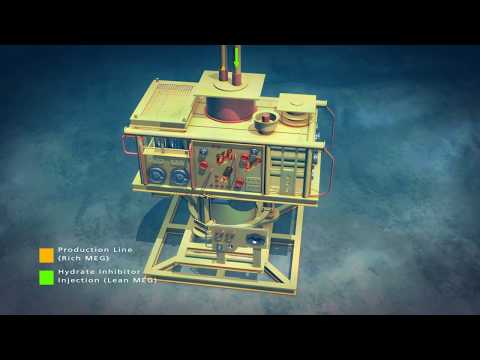

In [2]:
#@title MEG reclamation
#@markdown This video gives an intriduction to MEG reclamation
from IPython.display import YouTubeVideo
YouTubeVideo('4HosHcGvtVM', width=600, height=400)

# Simulation fo MEG regeneration

In [3]:
from neqsim.process import *
from neqsim.thermo.thermoTools import fluid, TPflash
from neqsim import jneqsim as neqsim
from neqsim.thermo import thermodynamicoperations

# -----------------------------------------------------------------------------
# 1) Create fluid (equivalent to new SystemSrkCPAstatoil(273.15 + 40, 6.0))
# -----------------------------------------------------------------------------
fluid1 = fluid('cpa', temperature=273.15 + 40.0, pressure=6.0)

# 2) Add components
fluid1.addComponent("nitrogen", 0.1)
fluid1.addComponent("CO2", 0.05)
fluid1.addComponent("methane", 9.0)
fluid1.addComponent("ethane", 0.5)
fluid1.addComponent("propane", 0.3)
fluid1.addComponent("water", 75.0)
fluid1.addComponent("MEG", 25.0)

# 3) Set mixing rule
fluid1.setMixingRule(10)  # 10 => classic CPA mixing rule

# 4) Perform a TP flash
TPflash(fluid1)

# 5) Extract phases as separate SystemInterfaces
#    phaseToSystem(0) => likely the gas phase
#    phaseToSystem(1) => likely the liquid phase
feedGas = fluid1.phaseToSystem(0)
feedMEG = fluid1.phaseToSystem(1)

# 6) Calculate weight fraction of MEG in the second phase
wtMEG = feedMEG.getPhase(0).getWtFrac("MEG") * 100.0

clearProcess()
# -----------------------------------------------------------------------------
# 7) Create process streams
# -----------------------------------------------------------------------------
stream1 = stream("stream 1", feedMEG)
stream1.setFlowRate(6000.0, "kg/hr")
stream1.setTemperature(80.0, "C")
stream1.setPressure(1.021, "bara")
stream1.run()

stripgas = stream("stream 2", feedGas)
stripgas.setFlowRate(10.0, "kg/hr")
stripgas.setTemperature(80.0, "C")
stripgas.setPressure(1.021, "bara")
stripgas.run()

# -----------------------------------------------------------------------------
# 8) Create and configure the distillation column
# -----------------------------------------------------------------------------
distillationColumn = neqsim.process.equipment.distillation.DistillationColumn("MEG column", 2, True, True)
distillationColumn.addFeedStream(stream1, 1)
distillationColumn.addFeedStream(stripgas, 1)

distillationColumn.getReboiler().setOutTemperature(273.15 + 140.0)  # 140 C
distillationColumn.getCondenser().setOutTemperature(273.15 + 35.0)  # 35 C

distillationColumn.setTopPressure(1.021)
distillationColumn.setBottomPressure(1.021)

# enable separation with liquid reflux => 370.0 kg/hr reflux flow
distillationColumn.getCondenser().setSeparation_with_liquid_reflux(True,
                                                                   370.0,
                                                                   "kg/hr")
# 9) Run the column simulation
distillationColumn.run()


In [4]:
print(f"""
---------- PROCESS RESULTS ----------
wt% MEG in feed : {wtMEG} kg/m3
density aqueous feed: {stream1.getFluid().getPhase("aqueous").getDensity('kg/m3')} kg/m3
Distillation column top gas flow: {distillationColumn.getGasOutStream().getFlowRate('kg/hr')} kg/hr
Distillation column top temperature: {distillationColumn.getGasOutStream().getTemperature('C')} °C
Distillation column bottom liquid flow: {distillationColumn.getLiquidOutStream().getFlowRate('kg/hr')} kg/hr
Split to water treatment: {distillationColumn.getCondenser().getLiquidProductStream().getFlowRate('kg/hr')} kg/hr
Split to recycle to column: {distillationColumn.getCondenser().getLiquidOutStream().getFlowRate('kg/hr')} kg/hr
wt% MEG to water treatment: {distillationColumn.getCondenser().getLiquidProductStream().getFluid().getPhase(0).getWtFrac('MEG') * 100.0} wt%
flow MEG to water treatment: {distillationColumn.getCondenser().getLiquidProductStream().getFluid().getComponent('MEG').getFlowRate('kg/hr')} kg/hr
density reflux: {distillationColumn.getCondenser().getLiquidProductStream().getFluid().getDensity('kg/m3')} kg/m3
wt% MEG in bottom: {distillationColumn.getLiquidOutStream().getFluid().getPhase(0).getWtFrac('MEG') * 100.0} wt%
KOF: {distillationColumn.getCondenser().getLiquidProductStream().getFluid().getPhase(0).getWtFrac('MEG') * 1.0e6 / 1.547} KOF
Reboiler duty: {distillationColumn.getReboiler().getDuty() / 1.0e6} MW
Condenser duty: {distillationColumn.getCondenser().getDuty() / 1.0e6} MW
Reboiler temperature: {distillationColumn.getReboiler().getTemperature()-273.15} °C
Tray 1 temperature: {distillationColumn.getTray(1).getTemperature()-273.15} °C
Tray 2 temperature: {distillationColumn.getTray(2).getTemperature()-273.15} °C
Condenser temperature: {distillationColumn.getCondenser().getTemperature()-273.15} °C
""".strip())

---------- PROCESS RESULTS ----------
wt% MEG in feed : 53.47432276970925 kg/m3
density aqueous feed: 1019.2053713967271 kg/m3
Distillation column top gas flow: 11.660130291918966 kg/hr
Distillation column top temperature: 35.0 °C
Distillation column bottom liquid flow: 3530.6582478819814 kg/hr
Split to water treatment: 2467.6855122179463 kg/hr
Split to recycle to column: 1270.0 kg/hr
wt% MEG to water treatment: 0.19295449444491125 wt%
flow MEG to water treatment: 4.761510104590457 kg/hr
density reflux: 992.1662324259032 kg/m3
wt% MEG in bottom: 90.7396421283869 wt%
KOF: 1247.2817999024646 KOF
Reboiler duty: 2.4826164948696285 MW
Condenser duty: -2.57898618801929 MW
Reboiler temperature: 140.0 °C
Tray 1 temperature: 110.12385188128417 °C
Tray 2 temperature: 101.27324974234602 °C
Condenser temperature: 35.0 °C


# Printing streams

In [5]:
printFrame(distillationColumn.getCondenser().getFluid())
printFrame(distillationColumn.getReboiler().getFluid())

| 0                    | 1          | 2                    | 3                    | 4   | 5   | 6               |
|:---------------------|:-----------|:---------------------|:---------------------|:----|:----|:----------------|
|                      | total      | GAS                  | AQUEOUS              |     |     |                 |
| nitrogen             | 2.81278E-5 | 9.01821E-3           | 9.20431E-8           |     |     | [mole fraction] |
| CO2                  | 3.23755E-5 | 9.21341E-3           | 3.74427E-6           |     |     | [mole fraction] |
| methane              | 2.65143E-3 | 8.46546E-1           | 1.97243E-5           |     |     | [mole fraction] |
| ethane               | 1.5901E-4  | 5.05547E-2           | 1.85039E-6           |     |     | [mole fraction] |
| propane              | 9.10625E-5 | 2.91921E-2           | 3.10229E-7           |     |     | [mole fraction] |
| water                | 9.96479E-1 | 5.5475E-2            | 9.99413E-1           |     

# Run studies to evaluate MEG to water treatment plant

## Study to see effect of reflux rate from 300 kg/hr to 1300 kg/hr

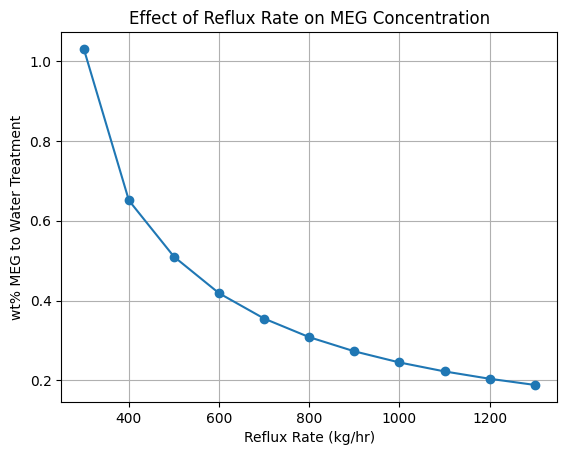

In [6]:
import matplotlib.pyplot as plt
import numpy as np

reflux_rates = np.arange(300, 1301, 100)  # Reflux rates from 300 to 1300 kg/hr
meg_wt_percentages = []

for reflux_rate in reflux_rates:
    # Set reflux rate for the distillation column
    distillationColumn.getCondenser().setSeparation_with_liquid_reflux(True, reflux_rate, "kg/hr")

    # Run the column simulation
    distillationColumn.run()

    # Calculate and store wt% MEG to water treatment
    meg_wt_percentage = distillationColumn.getCondenser().getLiquidProductStream().getFluid().getPhase(0).getWtFrac('MEG') * 100.0
    meg_wt_percentages.append(meg_wt_percentage)

# Plotting the results
plt.plot(reflux_rates, meg_wt_percentages, marker='o')
plt.xlabel("Reflux Rate (kg/hr)")
plt.ylabel("wt% MEG to Water Treatment")
plt.title("Effect of Reflux Rate on MEG Concentration")
plt.grid(True)
plt.show()

## Study to see effect of reflux rate from 3% to 12% of feed flow rate

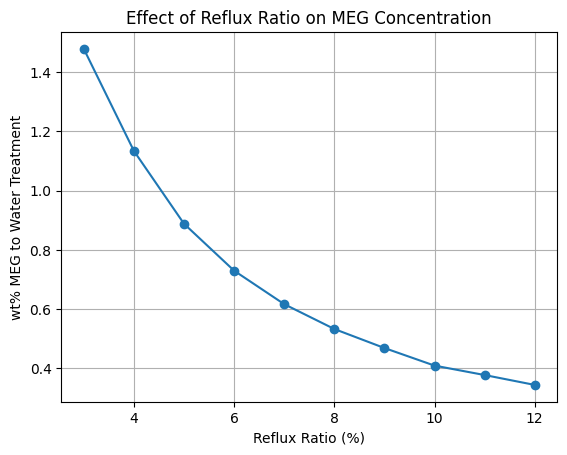

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Get the feed flow rate
feed_flow_rate = stream1.getFlowRate("kg/hr")

# Define reflux ratios (3% to 12%)
reflux_ratios = np.arange(0.03, 0.13, 0.01)

meg_wt_percentages = []

for reflux_ratio in reflux_ratios:
    # Calculate reflux rate based on reflux ratio and feed flow rate
    reflux_rate = reflux_ratio * feed_flow_rate

    # Set reflux rate for the distillation column
    distillationColumn.getCondenser().setSeparation_with_liquid_reflux(True, reflux_rate, "kg/hr")

    # Run the column simulation
    distillationColumn.run()

    # Calculate and store wt% MEG to water treatment
    meg_wt_percentage = distillationColumn.getCondenser().getLiquidProductStream().getFluid().getPhase(0).getWtFrac('MEG') * 100.0
    meg_wt_percentages.append(meg_wt_percentage)

# Plotting the results
plt.plot(reflux_ratios * 100, meg_wt_percentages, marker='o')  # Plot reflux ratios in percentage
plt.xlabel("Reflux Ratio (%)")
plt.ylabel("wt% MEG to Water Treatment")
plt.title("Effect of Reflux Ratio on MEG Concentration")
plt.grid(True)
plt.show()